In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
! ls

All_samples.pdf
All_samples.png
All_samples.svg
calculate_froh.py
conGen_100window_50minSNPs_10stepSize_9September2018_hetMat_100
conGen_100window_50minSNPs_10stepSize_9September2018_IBDStatusMatrix_100
conGen_100window_50minSNPs_10stepSize_9September2018_ibdTracts_100
conGen_100window_50minSNPs_10stepSize_9September2018_nSNPMatrix_100
conGen_100window_50minSNPs_10stepSize_9September2018_windowInformationMatrix_100
conGen_100window_50minSNPs_10stepSize_9September2018_windowLODScoreMatrix_100
conGen_20window_10minSNPs_5stepSize_9September2018_hetMat_20
conGen_20window_10minSNPs_5stepSize_9September2018_IBDStatusMatrix_20
conGen_20window_10minSNPs_5stepSize_9September2018_ibdTracts_20
conGen_20window_10minSNPs_5stepSize_9September2018_nSNPMatrix_20
conGen_20window_10minSNPs_5stepSize_9September2018_windowInformationMatrix_20
conGen_20window_10minSNPs_5stepSize_9September2018_windowLODScoreMatrix_20
Het_plots
HetPlots.ipynb
High_low_inbreeding.pdf
High_low_inbreeding.png
High_low_inbreedi

In [30]:
! vcftools --freq --out VCF_sorted.ragoo.vcf --gzvcf VCF_sorted.ragoo.vcf.gz
! awk '{if (NR>1) {ref=$5; alt=$6; \
        freq=$6; gsub(":.*", "", ref); gsub(":.*", "", alt); gsub("^[A-Z]:", "", freq); \
        OFS="\t"; print $1,$2, ref "," alt, freq} }' VCF_sorted.ragoo.vcf.frq | bgzip -c > VCF_sorted.ragoo.beagle.frq.AF_file.txt.gz;
! tabix -b 2 -e 2 -s 1 VCF_sorted.ragoo.beagle.frq.AF_file.txt.gz;


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf VCF_sorted.ragoo.vcf.gz
	--freq
	--out VCF_sorted.ragoo.vcf

Using zlib version: 1.2.11
After filtering, kept 177 out of 177 Individuals
Outputting Frequency Statistics...
After filtering, kept 43967 out of a possible 43967 Sites
Run Time = 2.00 seconds


In [31]:
! /software/stable/hts/1.9/x86_64/bin/bcftools roh -G 30 -O rz --AF-file VCF_sorted.ragoo.beagle.frq.AF_file.txt.gz VCF_sorted.ragoo.vcf.gz > VCF_sorted.ragoo.vcf.bcftools_roh.gz

[W::bcf_hdr_check_sanity] GL should be declared as Number=G
Number of target samples: 177
Number of --estimate-AF samples: 0
Number of sites in the buffer/overlap: unlimited
Number of lines overlapping with --AF-file/processed: 43967/23196
Number of lines filtered/no AF/not biallelic/dup: 0/7/0/1


In [111]:
! python calculate_froh.py -r ragoo.fasta  VCF_sorted.ragoo.vcf.bcftools_roh.gz VCF_sorted.ragoo.vcf.bcftools_roh.txt

In [2]:
windows = pd.read_csv("conGen_100window_50minSNPs_10stepSize_9September2018_windowInformationMatrix_100",
                     delimiter=" ")

In [3]:
ibd = pd.read_csv("conGen_100window_50minSNPs_10stepSize_9September2018_ibdTracts_100", delimiter=" ",
                 header=None, names=["indv", "chrom", "start", "end"])

In [4]:
hetmat = pd.read_csv("conGen_100window_50minSNPs_10stepSize_9September2018_hetMat_100", delimiter=" ")

In [5]:
print(hetmat.shape)
print(windows.shape)

hetmat = pd.concat([windows, hetmat], axis=1)

(3850, 177)
(3850, 5)


In [6]:
ped= pd.read_csv("../iaa_pedigree.ped", delimiter="\t", header=None,
           names=["Pop", "bam", "father", "mother", "sex", "phenotype", "sample_id", "father_id", "mother_id"])

In [7]:
pdlinks = pd.read_excel("../pedigree links .xlsx", index_col=[0])
pops = pd.read_excel("../coloured_subpops.xlsx")
pops[pops.columns[0]] = pops[pops.columns[0]].astype(str).str.replace("\s*", "").str.replace("^6_", "6-")
trios = pd.read_excel("../PP_Trios.xlsx")

# Correcting the IDs according to the information sent by Camila
subs = {"s140": "6A00428",
        "s152": "6A00427",
        "s24": "6A00412",
        "s242": "6A00435",
        "s251": "6A00438"}

pdlinks.loc[pdlinks["Father(s)"] == 964, "Father(s)"] = "O964"
pdlinks.loc[pdlinks["Father(s)"] == "964", "Father(s)"] = "O964"

for key, val in subs.items():
    trios.loc[trios["Offspring"] == key, "Offspring"] = val
    assert key not in trios.Offspring
    pops.loc[pops["Bird ID "] == key, "Bird ID "] = val
    assert key not in pops["Bird ID "]

trios.set_index("Offspring", inplace=True)
pops.set_index("Bird ID ", inplace=True)

pops.index = pops.index.astype(str)
print("malformed", pdlinks.index[pdlinks.index.astype(str).str.contains("\(")])

pdlinks.index = pdlinks.index.astype(str).str.replace(r"=.*", "").str.replace(r" \(.*", "").str.replace(r"\s", "")
pdlinks["Father(s)"] = pdlinks["Father(s)"].astype(str).str.replace(
    r"=.*", "").str.replace(r" \(.*", "").str.replace(r"\s", "")
pdlinks["Mother(s)"] = pdlinks["Mother(s)"].astype(str).str.replace(
    r"=.*", "").str.replace(r" \(.*", "").str.replace(r"\s", "").str.replace(r"W$", "")

trios.index = trios.index.astype(str).str.replace("\s*", "").str.replace("^6_", "6-")
for index in range(len(trios.columns)):
    trios[trios.columns[index]] = trios[trios.columns[index]].astype(str).str.replace("\s*", "").str.replace("^6_", "6-")


malformed Index(['6-22891 (Combo)', '6A00413 (s14)'], dtype='object', name='ID')


In [8]:
pops[pops["Popu"] == "IAA"].index

Index(['6-22998', '6-22858', '6-22864', '6-22869', '6-22870', '6-22896',
       '6-22897', '6-22958', '6-22961', '6-22962',
       ...
       's337', 's340', 's346', 's349', 's383', 's54', 's55', 's70', 's76',
       's92'],
      dtype='object', name='Bird ID ', length=116)

In [9]:
froh = pd.read_csv("VCF_sorted.ragoo.vcf.bcftools_roh.txt", delimiter="\t", names=["sample", "rohtot", "froh"])

In [10]:
pdlinks[pdlinks.index.str.contains("6A00437")]

,SEX,[Number]Mate(s),Father(s),Mother(s),[Number]Siblings,[Number]Half Siblings,[Number]Step Siblings,Other Siblings,[Number]Children
ID,,,,,,,,,
6A00437,Male,NaN,6A00410,6A00419,"[2] 6A00435=s242, 6A00427=s152",NaN,NaN,NaN,NaN


In [11]:
import numpy as np

pdlinks = pd.read_excel("../pedigree links .xlsx", index_col=[0])
pdlinks.index = pdlinks.index.astype(str).str.replace(r"=.*", "").str.replace(r" \(.*", "").str.replace(r"\s", "")
pdlinks.loc[pdlinks["Father(s)"] == 964, "Father(s)"] = "O964"
pdlinks.loc[pdlinks["Father(s)"] == "964", "Father(s)"] = "O964"
pdlinks["Father(s)"] = pdlinks["Father(s)"].astype(str).str.replace(
                       r"=.*", "").str.replace(r" \(.*", "").str.replace(r"\s", "")
pdlinks["Mother(s)"] = pdlinks["Mother(s)"].astype(str).str.replace(
                       r"=.*", "").str.replace(r" \(.*", "").str.replace(r"\s", "").str.replace(r"W$", "")
pdlinks.index = pdlinks.index.astype(str).str.replace(r"=.*", "").str.replace(
                       r" \(.*", "").str.replace(r"\s", "").str.replace(r"W$", "")
pdlinks.index = pdlinks.index.str.replace("^S", "s")
pdlinks.loc[pdlinks["Father(s)"] == 964, "Father(s)"] = "O964"
pdlinks.loc[pdlinks["Father(s)"] == "964", "Father(s)"] = "O964"

kinship2 = pdlinks.loc[:, ["Father(s)", "Mother(s)", "SEX"]]
kinship2.replace("nan", np.nan, inplace=True)

kinship2.columns = ["Father", "Mother", "Sex"]
kinship2.loc[kinship2.Sex == "Male", "Sex"] = "M"
kinship2.loc[kinship2.Sex == "Female", "Sex"] = "F"
kinship2.loc[kinship2.Sex == "Unknown Gender", "Sex"] = 0
kinship2.reset_index(0, inplace=True)
# Manual substitutions

print(list(kinship2.loc[kinship2.ID.str.contains(
                              "6A00447", na=False), kinship2.columns[1:]].values))

serial = pd.Series(["s337"] +
                          list(*kinship2.loc[kinship2.ID.str.contains(
                              "6A00447", na=False), kinship2.columns[1:]].values), index=kinship2.columns)
kinship2 = kinship2.append([serial], ignore_index=True)

kinship2.loc[kinship2.ID.str.contains("6A00451", na=False), "ID"] = "s349"
kinship2.loc[kinship2.ID.str.contains("6-22962W", na=False), "ID"] = "6-22962"
kinship2.loc[kinship2.ID.str.contains("wi[a-z]*ld", case=False, regex=True), "ID"] = np.nan
kinship2.loc[kinship2.ID.str.contains("unk", case=False, regex=True, na=False), "ID"] = np.nan
kinship2 = kinship2.loc[~kinship2.ID.isna()]
kinship2.loc[kinship2.Father.str.contains("wi[a-z]*ld", case=False, na=False, regex=True), "Father"] = np.nan
kinship2.loc[kinship2.Father.str.contains("unk", case=False, na=False, regex=True), "Father"] = np.nan
kinship2.loc[kinship2.Mother.str.contains("wi[a-z]*ld", case=False, na=False, regex=True), "Mother"] = np.nan
kinship2.loc[kinship2.Mother.str.contains("unk", case=False, na=False, regex=True), "Mother"] = np.nan
kinship2.insert(0, "family", ["IAA"] * kinship2.shape[0])
kinship2.head()
kinship2["Father"] = kinship2.Father.str.replace("\[2\]([^,]*),.*", r'\1')

missing_fathers = kinship2[~kinship2.Father.isin(kinship2.ID)].Father.dropna().values
if missing_fathers.shape[0]:
    kinship2 = kinship2.append([pd.Series(["IAA", indv, np.nan, np.nan, "M"], index=kinship2.columns) for indv in missing_fathers],
                              ignore_index=True)
else:
    print("All fathers accounted for")
missing_mothers = kinship2[~kinship2.Mother.isin(kinship2.ID)].Mother.dropna().values
if missing_mothers.shape[0]:
    kinship2 = kinship2.append([pd.Series(["IAA", indv, np.nan, np.nan, "F"], index=kinship2.columns) for indv in missing_mothers],
                              ignore_index=True)
else:
    print("All mothers accounted for")    
kinship2.drop_duplicates(inplace=True)

kinship2.to_csv("iaa_complete.ped", sep="\t", na_rep='0', header=False, index=False)

[array(['6-23004', '6-23195', 0], dtype=object)]
All mothers accounted for


In [12]:
# # Create the PED file from the inbred data set

# inbred = pd.read_excel("../All Sites Studbook Oct 2010.xlsx", sheet_name=3)
# # inbred[[" Ring no.", "Sire ID", "Dam ID", " Sex"]].head()
# kinship =  inbred.loc[:, [" Ring no.", "Sire ID", "Dam ID", " Sex"]]
# kinship.columns = ["ID", "Father", "Mother", "Sex"]
# kinship.loc[kinship["ID"] == 'none', 'ID'] = np.nan
# kinship.loc[kinship["Sex"].isin(("NA", "U")), "Sex"] = 0
# kinship.loc[kinship["Sex"].isin(("F?", )), "Sex"] = "F"
# kinship.loc[kinship["Sex"].isin(("M?", )), "Sex"] = "M"
# kinship.loc[kinship.Father == "wild", "Father"] = np.nan
# kinship.loc[kinship.Mother == "wild", "Mother"] = np.nan

# # Now supplement things from the pdlinks dataframe

# missing_individuals = 


# kinship.loc[kinship.Sex.isna(), "Sex"] = 0
# kinship = kinship.loc[~kinship.ID.isna(), :]
# kinship.insert(0, "family", ["IAA"] * kinship.shape[0])
# for num in (734, 735, 736, 738, 740, 951, 952, 955):
#     kinship.replace(str(num), num, inplace=True)
#     kinship.replace('0' + str(num), num, inplace=True)
# kinship.replace('6-22862?', '6-22862', inplace=True)
# missing_fathers = kinship[~kinship.Father.isin(kinship.ID)].Father.dropna().values
# missing_mothers = kinship[~kinship.Mother.isin(kinship.ID)].Mother.dropna().values
# kinship = kinship.append([pd.Series(["IAA", indv, np.nan, np.nan, "M"], index=kinship.columns) for indv in missing_fathers],
#                           ignore_index=True)
# kinship = kinship.append([pd.Series(["IAA", indv, np.nan, np.nan, "F"], index=kinship.columns) for indv in missing_mothers],
#                           ignore_index=True)




# kinship.to_csv("iaa_complete.ped", sep="\t", na_rep='0', header=False, index=False)

In [13]:
# From pydigree, https://github.com/jameshicks/pydigree
! kinship.py --file iaa_complete.ped | awk '{OFS="\t"; if ($2==$3) {print $2,$4}}'  > iaa_complete.kinship.txt

/bin/sh: 1: kinship.py: not found


In [14]:
inbred = pd.read_excel("../All Sites Studbook Oct 2010.xlsx", sheet_name=3)
# print(inbred.columns)

inbred["Inbreeding coeff"] = inbred["Inbreeding coeff"].replace("unk", np.nan)
print(inbred.shape, inbred[inbred["Inbreeding coeff"].isna()].shape)
iaa_subset = pd.merge(pops[pops.Popu == "IAA"], inbred, right_on=[" Ring no."], left_index=True, how="outer")
iaa_subset = iaa_subset[iaa_subset["bam name"].str.replace("6-", "6.").isin(hetmat.columns)][[' Ring no.', 'bam name', 'Inbreeding coeff']]
# [[' Ring no.', 'Inbreeding coeff']]
iaa_subset.columns = ["Ring", "Bam", "Inbreeding"]
# iaa_subset.drop(iaa_subset[iaa_subset.Ring == "6A00447"].index, inplace=True)
import numpy as np
# iaa_subset["Inbreeding"] = iaa_subset["Inbreeding"].replace('unk', np.nan).astype(float)
fped = pd.read_csv("iaa_complete.kinship.txt", delimiter="\t", header=None, names=["sample", "fped"])
fped.loc[fped["sample"] == 964, "sample"] = "O964"
fped.loc[fped["sample"] == "964", "sample"] = "O964"
fped.loc[fped["sample"] == "0964", "sample"] = "O964"
iaa_subset = pd.merge(iaa_subset, froh, left_on="Bam", right_on="sample")
iaa_subset = pd.merge(iaa_subset, fped, left_on="Ring", right_on="sample", how="left")
print(iaa_subset[iaa_subset.Ring == "6A00447"].values)
print(iaa_subset[iaa_subset.Ring == "s337"].values)

(427, 33) (267, 33)
[['6A00447'
  'Q41_adapt_filt_sbfi_filt_6A00447_R1adapt_filt_sbfi_filt_6A00447_R2rmdupread1.sorted.bam'
  nan
  'Q41_adapt_filt_sbfi_filt_6A00447_R1adapt_filt_sbfi_filt_6A00447_R2rmdupread1.sorted.bam'
  206865479 0.2054662576889968 '6A00447' 0.0691986083984375]]
[['s337'
  'Q41_adapt_filt_sbfi_filt_s337_R1adapt_filt_sbfi_filt_s337_R2rmdupread1.sorted.bam'
  nan
  'Q41_adapt_filt_sbfi_filt_s337_R1adapt_filt_sbfi_filt_s337_R2rmdupread1.sorted.bam'
  206865479 0.2054662576889968 's337' 0.0691986083984375]]


In [15]:
plink = pd.read_csv("plink.ibc", delimiter="\t")
plink.head()

,FID,IID,NOMISS,Fhat1,Fhat2,Fhat3
0,0,Q41_adapt_filt_sbfi_filt_6-22858_R1adapt_filt_...,43967,-0.116465,-0.114552,-0.070497
1,0,Q41_adapt_filt_sbfi_filt_6-22864_R1adapt_filt_...,43967,-0.136881,-0.065572,-0.056215
2,0,Q41_adapt_filt_sbfi_filt_6-22869_R1adapt_filt_...,43967,0.233341,-0.227753,0.047805
3,0,Q41_adapt_filt_sbfi_filt_6-22870_R1adapt_filt_...,43967,-0.223563,-0.027031,-0.080286
4,0,Q41_adapt_filt_sbfi_filt_6-22896_R1adapt_filt_...,43967,-0.132662,0.176137,0.066749


In [16]:
iaa_subset = pd.merge(iaa_subset, plink, left_on="Bam", right_on="IID")

In [17]:
import scipy.stats

no_nans = iaa_subset.loc[~(iaa_subset.froh.isna() | iaa_subset.fped.isna()), ["froh", "fped"]]

print(iaa_subset[iaa_subset.fped.isna()].Ring.values)

[]


(80, 14)
(0.03990749639857252, 0.669232795356974)
(80, 14)


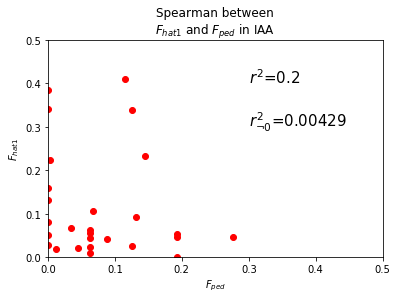

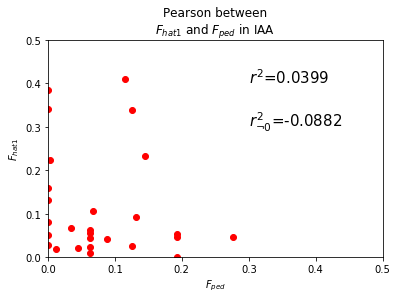

In [18]:
from matplotlib import pyplot as plt
import scipy.stats

figure, subplots = plt.subplots(1)
plot = subplots
plot.scatter(iaa_subset.fped, iaa_subset.Fhat1, c="r")
plot.set_xlim(0, 0.5)
plot.set_ylim(0, 0.5)
plot.set_xlabel("$F_{ped}$")
plot.set_ylabel("$F_{hat1}$")
r2 = scipy.stats.spearmanr(iaa_subset.Fhat1, iaa_subset.fped).correlation
not_zero = iaa_subset.loc[iaa_subset.fped > 0, :]
non0r2 = scipy.stats.spearmanr(not_zero.Fhat1, not_zero.fped).correlation
print(not_zero.shape)
plot.annotate("$r^2$={:.3}".format(r2), (.3, .4), fontsize=15)
plot.set_title("Spearman between\n$F_{hat1}$ and $F_{ped}$ in IAA")
plot.annotate(r"$r^2_{\neg0}$=" + "{:.3}".format(non0r2), (.3, .3), fontsize=15)

plt.savefig("fped_fhat1_spearman.pdf", dpi=300)


figure, subplots = plt.subplots(1)
plot = subplots
plot.scatter(iaa_subset.fped, iaa_subset.Fhat1, c="r")
plot.set_xlim(0, 0.5)
plot.set_ylim(0, 0.5)
plot.set_xlabel("$F_{ped}$")
plot.set_ylabel("$F_{hat1}$")
r2 = scipy.stats.pearsonr(iaa_subset.Fhat1, iaa_subset.fped)
print(r2)
r2 = r2[0]
not_zero = iaa_subset.loc[iaa_subset.fped > 0, :]
non0r2 = scipy.stats.pearsonr(not_zero.Fhat1, not_zero.fped)[0]
print(not_zero.shape)
plot.annotate("$r^2$={:.3}".format(r2), (.3, .4), fontsize=15)
plot.set_title("Pearson between\n$F_{hat1}$ and $F_{ped}$ in IAA")
plot.annotate(r"$r^2_{\neg0}$=" + "{:.3}".format(non0r2), (.3, .3), fontsize=15)

plt.savefig("fped_fhat1_pearson.pdf", dpi=300)

(80, 2)
(0.4668062492137196, 1.1256177470308457e-07)
(80, 2)


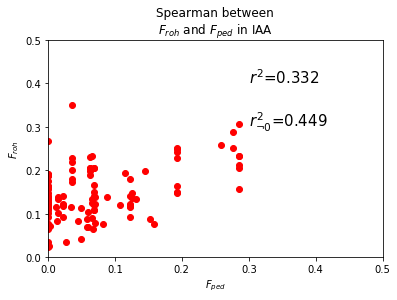

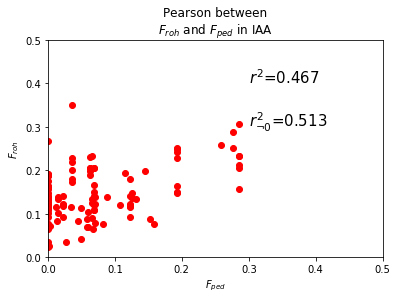

In [20]:
from matplotlib import pyplot as plt

figure, subplots = plt.subplots(1)
plot = subplots
plot.scatter(no_nans.fped, no_nans.froh, c="r")
plot.set_xlim(0, 0.5)
plot.set_ylim(0, 0.5)
plot.set_xlabel("$F_{ped}$")
plot.set_ylabel("$F_{roh}$")
r2 = scipy.stats.spearmanr(no_nans.froh, no_nans.fped).correlation
not_zero = no_nans.loc[no_nans.fped > 0, :]
non0r2 = scipy.stats.spearmanr(not_zero.froh, not_zero.fped).correlation
print(not_zero.shape)
plot.annotate("$r^2$={:.3}".format(r2), (.3, .4), fontsize=15)
plot.set_title("Spearman between\n$F_{roh}$ and $F_{ped}$ in IAA")
plot.annotate(r"$r^2_{\neg0}$=" + "{:.3}".format(non0r2), (.3, .3), fontsize=15)

plt.savefig("fped_froh_spearman.pdf", dpi=300)


figure, subplots = plt.subplots(1)
plot = subplots
plot.scatter(no_nans.fped, no_nans.froh, c="r")
plot.set_xlim(0, 0.5)
plot.set_ylim(0, 0.5)
plot.set_xlabel("$F_{ped}$")
plot.set_ylabel("$F_{roh}$")
r2 = scipy.stats.pearsonr(no_nans.froh, no_nans.fped)
print(r2)
r2 = r2[0]
not_zero = no_nans.loc[no_nans.fped > 0, :]
non0r2 = scipy.stats.pearsonr(not_zero.froh, not_zero.fped)[0]
print(not_zero.shape)
plot.annotate("$r^2$={:.3}".format(r2), (.3, .4), fontsize=15)
plot.set_title("Pearson between\n$F_{roh}$ and $F_{ped}$ in IAA")
plot.annotate(r"$r^2_{\neg0}$=" + "{:.3}".format(non0r2), (.3, .3), fontsize=15)

plt.savefig("fped_froh_pearson.pdf", dpi=300)

In [302]:
iaa_subset[iaa_subset.fped == 0].shape

(39, 8)

[0.90108589 0.80474059 0.70839529 0.61204998 0.51570468 0.41935938
 0.32301408 0.22666878 0.13032348]


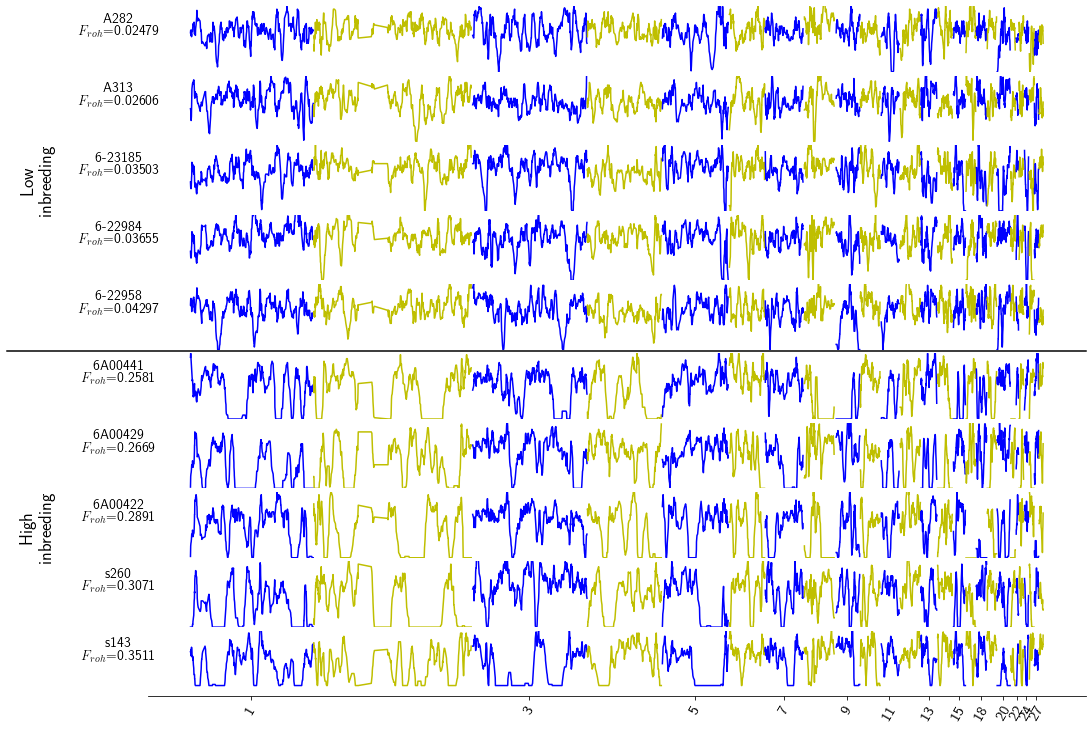

In [198]:
cols = ["b", "y"]

chroms = ['1_RaGOO',
          # '1A_RaGOO',
          '2_RaGOO',
          '3_RaGOO',
          '4_RaGOO',
          # '4A_RaGOO',
          # '4_random_RaGOO',
          '5_RaGOO',
          '6_RaGOO',
          '7_RaGOO',
          '8_RaGOO',
          '9_RaGOO',
          '10_RaGOO', '11_RaGOO', '12_RaGOO', '13_RaGOO', '14_RaGOO', 
          '15_RaGOO', '17_RaGOO', '18_RaGOO', '19_RaGOO',
          '20_RaGOO', '21_RaGOO', '22_RaGOO', '23_RaGOO', '24_RaGOO', '26_RaGOO',
          '27_RaGOO', '28_RaGOO', 
          #'Z_RaGOO'
         ]


import os
import re
if not os.path.exists("Het_plots"):
    os.makedirs("Het_plots")

import matplotlib

matplotlib.rcParams['text.usetex'] = True

import pysam
import numpy as np
fai = pysam.FastaFile("ragoo.fasta")

# for iidv, name in enumerate(pops[pops["bam name"].isin(hetmat.columns)].index):

figure, subplots = plt.subplots(10, 1, figsize=(14, 10), sharex=False)

not_inbred = iaa_subset.sort_values(by=["froh"], ascending=True).head(5)
inbred = iaa_subset.sort_values(by=["froh"], ascending=True).tail(5)

import itertools

maximum = 0

for iindx, (_, row) in enumerate(itertools.chain(not_inbred.iterrows(), inbred.iterrows())):
    # print(iindx, row)
    name = row["Ring"]
    coeff = row["Inbreeding"]
    indv = row["Bam"]
    froh = row["froh"]
    # indv = pops.loc[name]["bam name"]
    # print(name)
    indv = re.sub("6-", "6.", indv)
    # figure.suptitle(name)
    plot = subplots[iindx]
    prev = 0
#     plot.set_ylabel("{name}\n$F_{{ped}}$={:.4}\n$F_{{roh}}$={:.4}".format(coeff, froh,
#                                                                          name=name), rotation=0,
#                     labelpad=30)
    plot.set_ylabel("{name}\n$F_{{roh}}$={:.4}".format(froh, name=name), rotation=0,
                    fontsize=14,
                    labelpad=30)
    start = 0
    indices = [0]
    plot.set_ylim(0, .5)
    for index, chrom in enumerate(chroms):
        color = cols[index % 2]
        chrom_name = chrom.split("_")[0]
        # plot.set_xlabel(chrom_name, rotation=60)
        data = hetmat[hetmat.chromVec == chrom][["startPosVec", "endPosVec", indv]]
        positions = data[["startPosVec", "endPosVec"]].mean(axis=1) / 10**5
        mpos = positions.max()
        positions += start
        plot.plot(positions, data[indv], c=color)
        start += mpos
        indices.append(start)
    if maximum == 0:
        maximum = start
        
    # plot.axis("off")
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plot.spines['left'].set_visible(False)
    indices = np.array(indices)
    indices = (indices[1:] + indices[:-1])/2

    index, labels = [], []
    for iii, (ind, lab) in enumerate(zip(indices, chroms)):
        if iii % 2 != 0:
            continue
        index.append(ind)
        labels.append(re.sub('_RaGOO', '', lab))
    plot.get_yaxis().set_ticks([])
    if iindx == (inbred.shape[0] + not_inbred.shape[0] - 1):
        plot.set_xticks(index)
        plot.set_xticklabels(labels, rotation=60, fontsize=15)
        plot.set_ylim(-.1, .5)
    else:
        plot.spines['bottom'].set_visible(False)
        plot.get_xaxis().set_ticks([])
        
        
    # plt.savefig(os.path.join("Het_plots", "{}_inbreeding_{}_froh_{}.png".format(name, coeff, froh)), size=(20, 10), dpi=300)
    continue
    pass

from matplotlib.lines import Line2D
########
# from here: https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

plt.tight_layout(pad=0, w_pad=0, h_pad=0.0)
r = figure.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(figure.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, subplots.flat)), mtrans.Bbox).reshape(subplots.shape)
#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(subplots.shape)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(subplots.shape)
# print(ymax[1:])
# print(ymin[:-1])

ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)
print(np.c_[ymax[1:], ymin[:-1]].mean(axis=1))

# # Draw a horizontal lines at those coordinates
for pos, y in enumerate(ys):
    if pos == 4:
        line = plt.Line2D([-0.07, 1], [y, y], color="black")
        figure.add_artist(line)
######

text1 = figure.text(-0.04, ys[2], "Low\ninbreeding", rotation=90, fontsize=18, ha="center")
text2 = figure.text(-0.04, ys[7], "High\ninbreeding", rotation=90, fontsize=18, ha="center")

# line = Line2D([0, 1], [.5, .5], color="k")
# figure.add_artist(line)
# line = Line2D([0, 1], [0, 0], color='b') #, transform=trans)    
plt.savefig("High_low_inbreeding.svg", dpi=300, format="svg",
            bbox_extra_artists=(line, text1, text2), bbox_inches='tight')
plt.savefig("High_low_inbreeding.pdf", dpi=300, format="pdf",
           bbox_extra_artists=(line, text1, text2), bbox_inches='tight')
plt.savefig("High_low_inbreeding.png", dpi=300, format="png",
           bbox_extra_artists=(line, text1, text2), bbox_inches='tight')
plt.show()
plt.close()

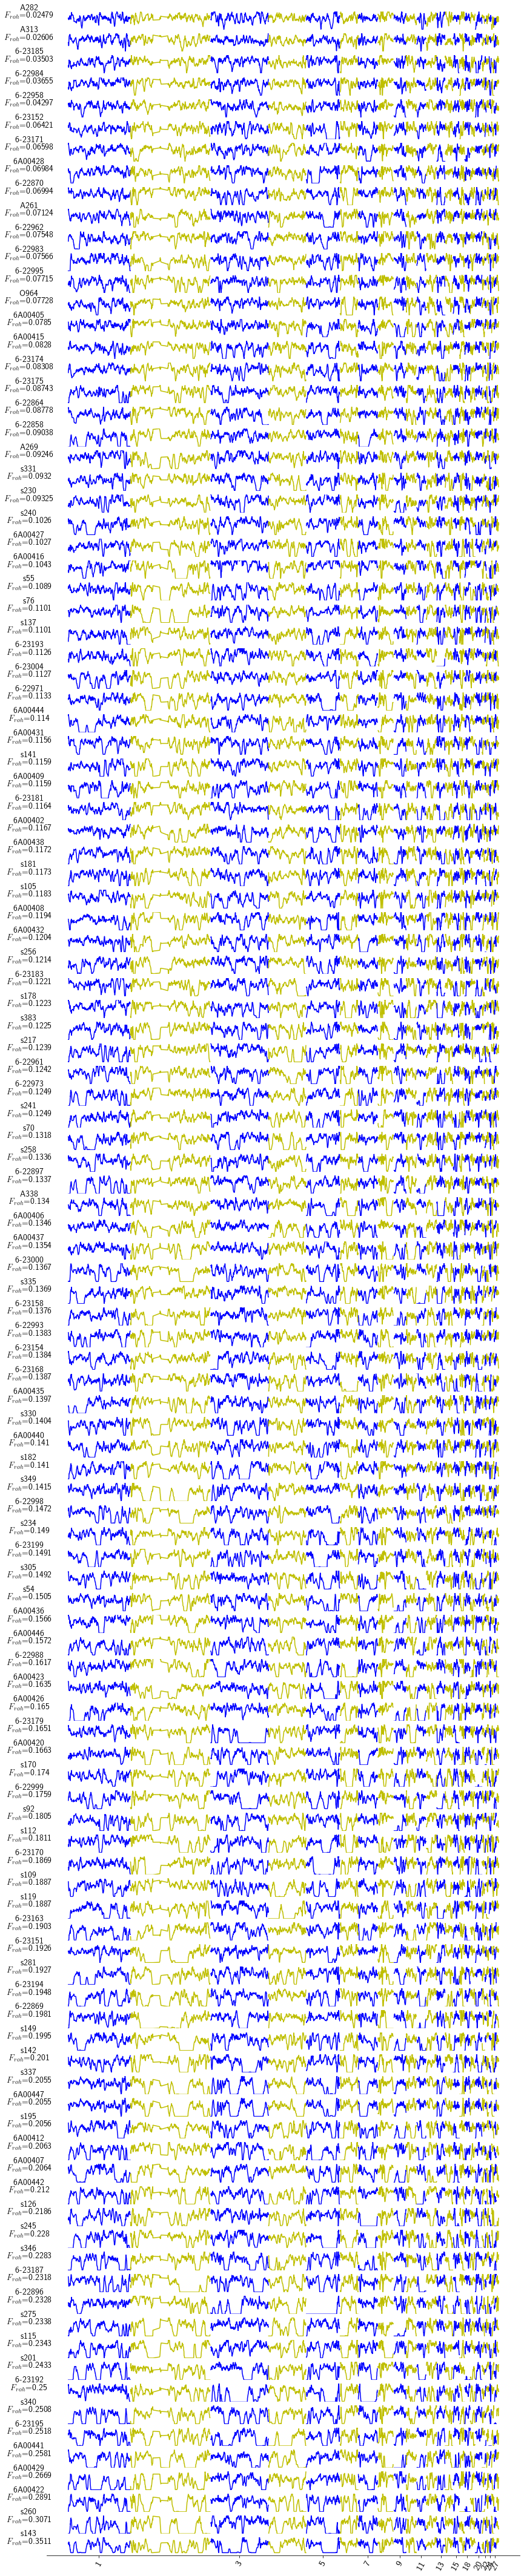

In [200]:
cols = ["b", "y"]

chroms = ['1_RaGOO',
          # '1A_RaGOO',
          '2_RaGOO',
          '3_RaGOO',
          '4_RaGOO',
          # '4A_RaGOO',
          # '4_random_RaGOO',
          '5_RaGOO',
          '6_RaGOO',
          '7_RaGOO',
          '8_RaGOO',
          '9_RaGOO',
          '10_RaGOO', '11_RaGOO', '12_RaGOO', '13_RaGOO', '14_RaGOO', 
          '15_RaGOO', '17_RaGOO', '18_RaGOO', '19_RaGOO',
          '20_RaGOO', '21_RaGOO', '22_RaGOO', '23_RaGOO', '24_RaGOO', '26_RaGOO',
          '27_RaGOO', '28_RaGOO', 
          #'Z_RaGOO'
         ]


import os
import re
if not os.path.exists("Het_plots"):
    os.makedirs("Het_plots")

import matplotlib

matplotlib.rcParams['text.usetex'] = True

import pysam
import numpy as np
fai = pysam.FastaFile("ragoo.fasta")

# for iidv, name in enumerate(pops[pops["bam name"].isin(hetmat.columns)].index):

ordered = iaa_subset.sort_values(by=["froh"], ascending=True)
figure, subplots = plt.subplots(ordered.shape[0], 1, figsize=(14, ordered.shape[0] * 2 / 3), sharex=False)

maximum = 0

for iindx, (_, row) in enumerate(ordered.iterrows()):
    # print(iindx, row)
    name = row["Ring"]
    coeff = row["Inbreeding"]
    indv = row["Bam"]
    froh = row["froh"]
    # indv = pops.loc[name]["bam name"]
    # print(name)
    indv = re.sub("6-", "6.", indv)
    # figure.suptitle(name)
    plot = subplots[iindx]
    prev = 0
#     plot.set_ylabel("{name}\n$F_{{ped}}$={:.4}\n$F_{{roh}}$={:.4}".format(coeff, froh,
#                                                                          name=name), rotation=0,
#                     labelpad=30)
    plot.set_ylabel("{name}\n$F_{{roh}}$={:.4}".format(froh, name=name), rotation=0,
                    fontsize=14,
                    labelpad=30)
    start = 0
    indices = [0]
    plot.set_ylim(0, .5)
    for index, chrom in enumerate(chroms):
        color = cols[index % 2]
        chrom_name = chrom.split("_")[0]
        # plot.set_xlabel(chrom_name, rotation=60)
        
        data = hetmat[hetmat.chromVec == chrom][["startPosVec", "endPosVec", indv]]
        positions = data[["startPosVec", "endPosVec"]].mean(axis=1) / 10**5
        mpos = positions.max()
        positions += start
        plot.plot(positions, data[indv], c=color)
        start += mpos
        indices.append(start)
    if maximum == 0:
        maximum = start
        
    # plot.axis("off")
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plot.spines['left'].set_visible(False)
    indices = np.array(indices)
    indices = (indices[1:] + indices[:-1])/2

    index, labels = [], []
    for iii, (ind, lab) in enumerate(zip(indices, chroms)):
        if iii % 2 != 0:
            continue
        index.append(ind)
        labels.append(re.sub('_RaGOO', '', lab))
    plot.get_yaxis().set_ticks([])
    if iindx == (ordered.shape[0] - 1):
        plot.set_xticks(index)
        plot.set_xticklabels(labels, rotation=60, fontsize=15)
        plot.set_ylim(-.1, .5)
    else:
        plot.spines['bottom'].set_visible(False)
        plot.get_xaxis().set_ticks([])
        
        
    # plt.savefig(os.path.join("Het_plots", "{}_inbreeding_{}_froh_{}.png".format(name, coeff, froh)), size=(20, 10), dpi=300)
    continue
    pass

# line = Line2D([0, 1], [.5, .5], color="k")
# figure.add_artist(line)
# line = Line2D([0, 1], [0, 0], color='b') #, transform=trans)    
plt.savefig("All_samples.svg", dpi=300, format="svg")
plt.savefig("All_samples.pdf", dpi=300, format="pdf",
           bbox_extra_artists=(line, text1, text2), bbox_inches='tight')
plt.savefig("All_samples.png", dpi=300, format="png",
           bbox_extra_artists=(line, text1, text2), bbox_inches='tight')
plt.show()
plt.close()

In [20]:
iaa_subset[iaa_subset.Inbreeding.isna()].shape

(81, 6)